# Unidad Práctica 3: Visualización de Mapas

Por **Eduardo Graells-Garrido**. <egraells@udd.cl>. 

Actualizado: **24 de marzo de 2022**.

En este notebook trabajaremos con información geográfica. Seguiremos estudiando el data set de viajes de la encuesta origen-destino, esta vez enfocándonos en distintos patrones geográficos que puedan ayudarnos a responder preguntas específicas.


## Google Colab

Para ejecutar este notebook en Colab, primero ejecuten la siguiente celda. Luego el notebook se reiniciará.

In [2]:
try:
    import google.colab
    !pip uninstall matplotlib -y
    !pip install -q condacolab
    
    import condacolab
    condacolab.install_mambaforge()
except ModuleNotFoundError:
    pass

Una vez que se ha reiniciado puedes ejecutar el resto de las celdas.

In [3]:
try:
    import google.colab
    !git clone https://github.com/zorzalerrante/aves.git aves_git
    !mamba env update --name base --file aves_git/environment-colab.yml
except ModuleNotFoundError:
    pass

## Preámbulo y Carga de Datos

In [4]:
import sys
from pathlib import Path

AVES_ROOT = Path("..") if not "google.colab" in sys.modules else Path("aves_git")

EOD_PATH = AVES_ROOT / "data" / "external" / "EOD_STGO"
EOD_PATH


PosixPath('../data/external/EOD_STGO')

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd

# esto configura la calidad de la imagen. dependerá de tu resolución. el valor por omisión es 80
mpl.rcParams["figure.dpi"] = 96
# esto depende de las fuentes que tengas instaladas en el sistema.
mpl.rcParams["font.family"] = "Fira Sans Extra Condensed"


In [6]:
from aves.data import eod

viajes = eod.read_trips(EOD_PATH)
personas = eod.read_people(EOD_PATH)
viajes_persona = viajes.merge(personas)

viajes_persona["PesoLaboral"] = (
    viajes_persona["FactorLaboralNormal"] * viajes_persona["Factor_LaboralNormal"]
)

viajes_persona = viajes_persona[pd.notnull(viajes_persona["PesoLaboral"])]

print(
    "{} viajes expandidos a {}".format(
        len(viajes_persona), int(viajes_persona["PesoLaboral"].sum())
    )
)


65591 viajes expandidos a 14566372


## ¿Dónde se concentran las personas que utilizan cada modo de transporte en la ciudad?

Es de interés saber dónde viven las personas que utilizan cada modo de transporte. Eso permite informar la planificación de nuevas redes de transporte y la gestión de las redes actuales.

Esta pregunta tiene una componente geográfica: el _dónde_. Si tuviésemos un enfoque de _tablas_, podríamos utilizar el atributo `Comuna` o `Sector` y resolver tareas del tipo parte-de-un-todo para conocer la distribución del uso de modo de transporte a través de las comunas o sectores.

Sin embargo, existe variabilidad dentro de les habitantes de cada comuna. Además, también es de interés saber si dos comunas/sectores/barrios/etc. cercanos tienen comportamiento similar, y si no, entender el contexto urbano que causa la diferencia.

Ante esa necesidad, un mapa es inmejorable. Pero, ¿cómo construir y configurar el mapa? Exploremos eso ahora.

Primero, veamos cómo luces las coordenadas que vienen dentro de los datos:

In [7]:
viajes_persona[
    ["OrigenCoordX", "OrigenCoordY", "DestinoCoordX", "DestinoCoordY"]
].head()


OrigenCoordX  OrigenCoordY  DestinoCoordX  DestinoCoordY
0   335208.7188     6288387.0    338812.3125      6292391.0
1   338812.2813     6292391.0    335208.7188      6288387.0
2   338536.4375     6291928.0    354267.3438      6302297.0
3   354267.3438     6302297.0    338536.4375      6291928.0
4   338536.4375     6291928.0    350841.6563      6297212.0

Si bien las coordenadas están en formato numérico, no las tenemos estructuradas en un `GeoDataFrame`. Para ello, usaremos la función `to_point_geodataframe` para darle contexto geográfico a los datos.  Crearemos dos estructuras, una para los orígenes de los viajes y otra para los destinos. Del notebook anterior ya conocemos el sistema de coordenadas:

In [8]:
from aves.features.geo import to_point_geodataframe

origenes_viajes = to_point_geodataframe(
    viajes_persona, "OrigenCoordX", "OrigenCoordY", crs="epsg:32719"
)
destinos_viajes = to_point_geodataframe(
    viajes_persona, "DestinoCoordX", "DestinoCoordY", crs="epsg:32719"
)


/home/egraells/miniconda3/envs/aves/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/egraells/miniconda3/envs/aves/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Cargamos el archivo GeoJSON que creamos en el notebook `03-python-mapas-preliminario.ipynb`:

In [9]:
zones = (
    gpd.read_file(AVES_ROOT / "data" / "processed" / "scl_zonas_urbanas.json")
    .set_index("ID")
    .to_crs(origenes_viajes.crs)
)
zones.head()


AREA   Zona    Com     Comuna REGION  \
ID                                              
103  837.7500  103.0  13105  El Bosque     13   
104  998.8125  104.0  13105  El Bosque     13   
106  286.2500  106.0  13105  El Bosque     13   
115  857.4375  115.0  13105  El Bosque     13   
116  853.9375  116.0  13105  El Bosque     13   

                           NOM_REGION PROVINCIA NOM_PROVIN NOM_COMUNA  \
ID                                                                      
103  REGIÓN METROPOLITANA DE SANTIAGO       131   SANTIAGO  EL BOSQUE   
104  REGIÓN METROPOLITANA DE SANTIAGO       131   SANTIAGO  EL BOSQUE   
106  REGIÓN METROPOLITANA DE SANTIAGO       131   SANTIAGO  EL BOSQUE   
115  REGIÓN METROPOLITANA DE SANTIAGO       131   SANTIAGO  EL BOSQUE   
116  REGIÓN METROPOLITANA DE SANTIAGO       131   SANTIAGO  EL BOSQUE   

        URBANO             TIPO NOM_CATEG  SHAPE_Leng  SHAPE_Area  \
ID                                                                  
103  EL BOSQUE  CAPITAL COMUNAL    CIUDAD    0.152123    0.001391   
104  EL BOSQUE  CAPITAL COMUNAL    CIUDAD    0.152123    0.001391   
106  EL BOSQUE  CAPITAL COMUNAL    CIUDAD    0.152123    0.001391   
115  EL BOSQUE  CAPITAL COMUNAL    CIUDAD    0.152123    0.001391   
116  EL BOSQUE  CAPITAL COMUNAL    CIUDAD    0.152123    0.001391   

          area_m2                                           geometry  
ID                                                                    
103  4.575649e+05  POLYGON ((346371.218 6285956.953, 346349.534 6...  
104  7.725462e+05  POLYGON ((344415.434 6285878.048, 344548.462 6...  
106  2.693838e+06  POLYGON ((342466.924 6284938.448, 342467.002 6...  
115  7.534193e+05  POLYGON ((344391.421 6285910.048, 344365.314 6...  
116  7.184305e+05  POLYGON ((345371.399 6286207.024, 345608.811 6...

Ahora nos aseguramos de tener orígenes y destinos que solo se dan dentro del contexto urbano determinado por el `GeoDataFrame` de `zonas`:

In [10]:
from aves.features.geo import clip_point_geodataframe

origenes_viajes = origenes_viajes[
    origenes_viajes["Viaje"].isin(destinos_viajes["Viaje"])
]
origenes_viajes = clip_point_geodataframe(origenes_viajes, zones.total_bounds)
destinos_viajes = destinos_viajes[
    destinos_viajes["Viaje"].isin(origenes_viajes["Viaje"])
]


Grafiquemos los datos. Utilizaremos la función `figure_from_geodataframe` de aves que configura los ejes de manera automática, y el método `plot` de geopandas puede graficar directamente los puntos de origen/destino:

<AxesSubplot:>

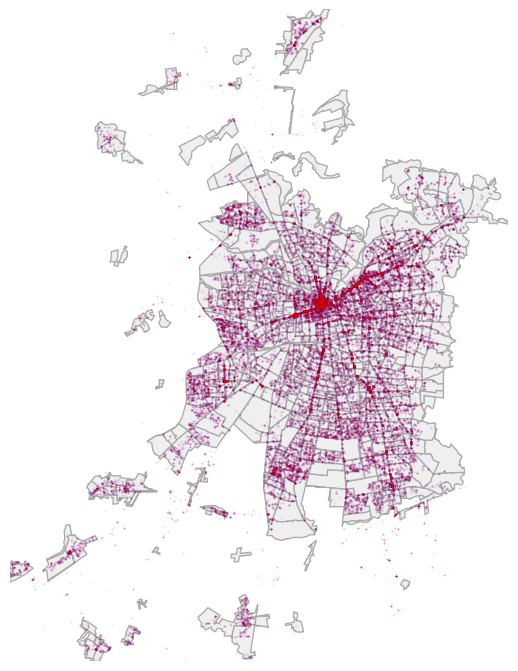

In [11]:
from aves.visualization.figures import figure_from_geodataframe

fig, ax = figure_from_geodataframe(zones, height=9, remove_axes=True)

zones.plot(ax=ax, color="#efefef", edgecolor="#abacab", linewidth=1)
origenes_viajes.plot(ax=ax, markersize=1, marker=".", color="blue", alpha=0.05)
destinos_viajes.plot(ax=ax, markersize=1, marker=".", color="red", alpha=0.05)


Nos damos cuenta que hay muchos datos. Tenemos que:

- **Filtrarlos**, es decir, decidir cuáles son relevantes para la tarea.
- **Visualizarlos** utilizando la técnica adecuada.

Para filtrarlos, fíjemonos en cuatro modos de transporte: público (`Bip!`), privado (`Auto`) y activo (`Caminata` y `Bicicleta`). Y por ahora veamos los viajes al trabajo.
Para visualizarlos, en aves tenemos una función `dot_map` que hace un mapa de puntos y que nos permitirá configurar algunos aspectos del gráfico considerando los aspectos que vimos en la clase teórica.

El gráfico se puede hacer así:

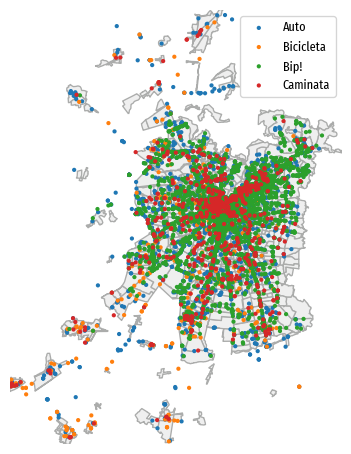

In [12]:
from aves.visualization.maps import dot_map

fig, ax = figure_from_geodataframe(zones, height=6, remove_axes=True)

zones.plot(ax=ax, color="#efefef", edgecolor="#abacab", linewidth=1)

for idx, group in origenes_viajes[(origenes_viajes.Proposito == "Al trabajo")].groupby(
    "ModoDifusion"
):
    if idx in ["Bip!", "Auto", "Caminata", "Bicicleta"]:
        dot_map(ax, group, size=10, label=idx)

ax.legend()


Notamos que cada categoría utiliza un tono de color distinto. Sin embargo, cuesta ver una posible distribución geográfica debido a la oclusión y aglomeramiento de los viajes.

Una posible solución es darle un tamaño a cada punto que sea proporcional al peso de los viajes. En tal caso, en vez de `dot_map` utilizaremos `bubble_map`:

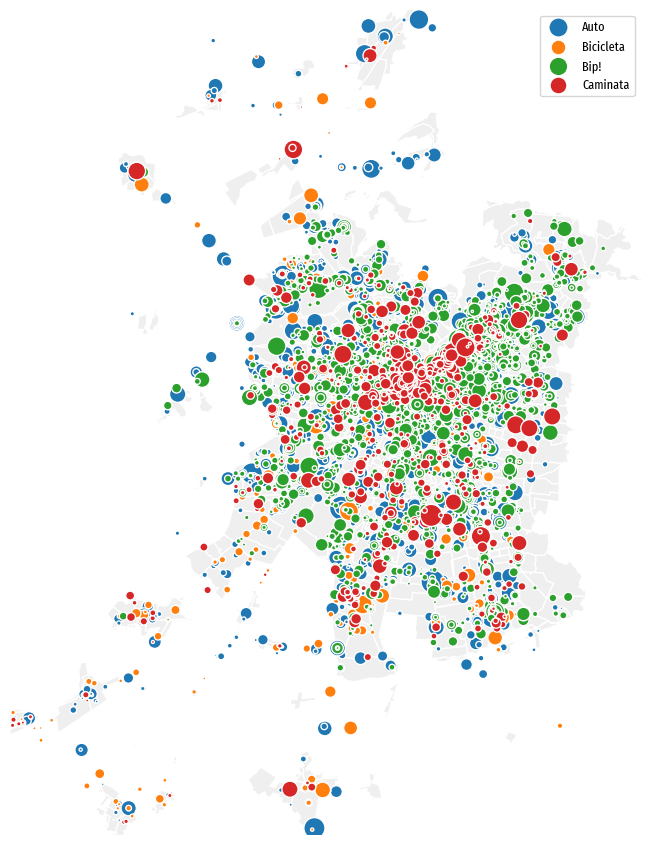

In [13]:
from aves.visualization.maps import bubble_map

fig, ax = figure_from_geodataframe(zones, height=9, remove_axes=True)

zones.plot(ax=ax, color="#efefef", edgecolor="white", linewidth=1)

for idx, group in origenes_viajes[(origenes_viajes.Proposito == "Al trabajo")].groupby(
    "ModoDifusion"
):
    if idx in ["Bip!", "Auto", "Caminata", "Bicicleta"]:
        bubble_map(ax, group, size="PesoLaboral", scale=0.15, label=idx)

ax.legend()

fig.tight_layout()


La idea sonaba bien, sin embargo, el gráfico no nos permite responder la pregunta (aunque es un lindo gráfico para compartir y contemplar). Esto se debe a varios factores, incluyendo la interferencia entre los canales utilizados en la codificación.

También la implementación del gráfico es compleja. Requiere ciclos a través de los resultados de una operación `groupby`.

Utilizaremos la grilla `GeoFacetGrid` de aves (inspirada en `FacetGrid` de seaborn) para hacer el mismo gráfico pero utilizando conceptos vistos en clase.

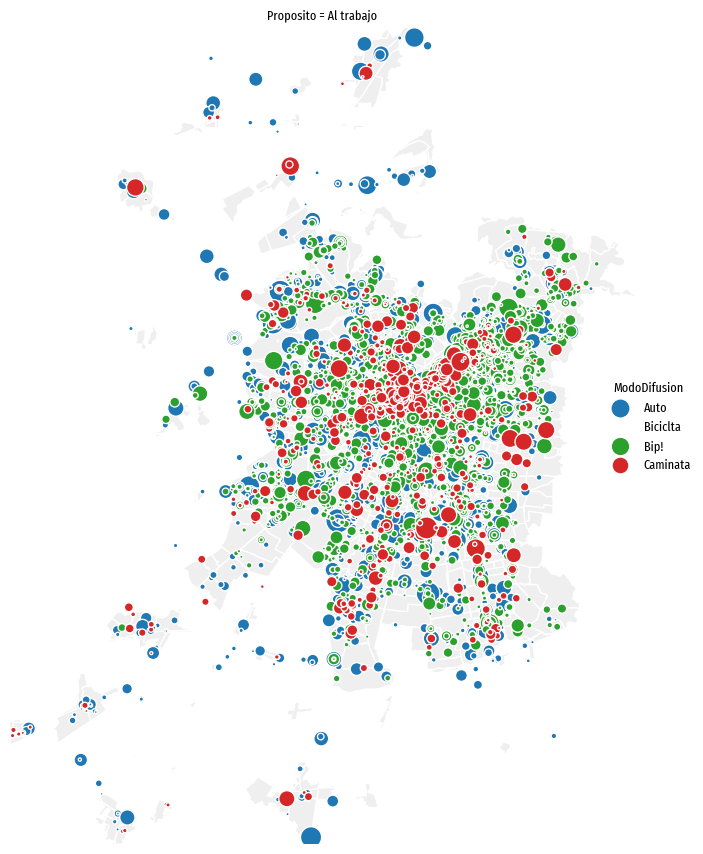

In [14]:
from aves.visualization.figures import GeoFacetGrid

grid = GeoFacetGrid(
    # los datos
    origenes_viajes,
    # el contexto geográfico. es opcional, se utiliza para configurar el gráfico
    context=zones,
    # la variable que mapearemos a las filas del gráfico
    row="Proposito",
    # en este caso, solo una fila
    row_order=["Al trabajo"],
    # el canal de codificación tono (hue) expresará la columna categórica ModoDifusion
    hue="ModoDifusion",
    # solo veremos estas categorías
    hue_order=["Auto", "Bicicleta", "Bip!", "Caminata"],
    # la altura del gráfico
    height=9,
)

# visualizamos el contexto
grid.add_layer(zones, color="#efefef", edgecolor="white", linewidth=1)

# agregamos los bubble_map correspondientes
grid.add_layer(bubble_map, size="PesoLaboral", scale=0.15)

# agregamos la leyenda
grid.add_legend()

grid.fig.tight_layout()


La implementación del gráfico es distinta, sin embargo, los problemas conceptuales se mantienen. Ahora bien, al utilizar la grilla, podemos utilizar sus opciones para reducir su complejidad a través de _facetas_.

Por ejemplo, podemos dividir el gráfico en columnas, donde cada columna muestra un modo de transporte diferente:

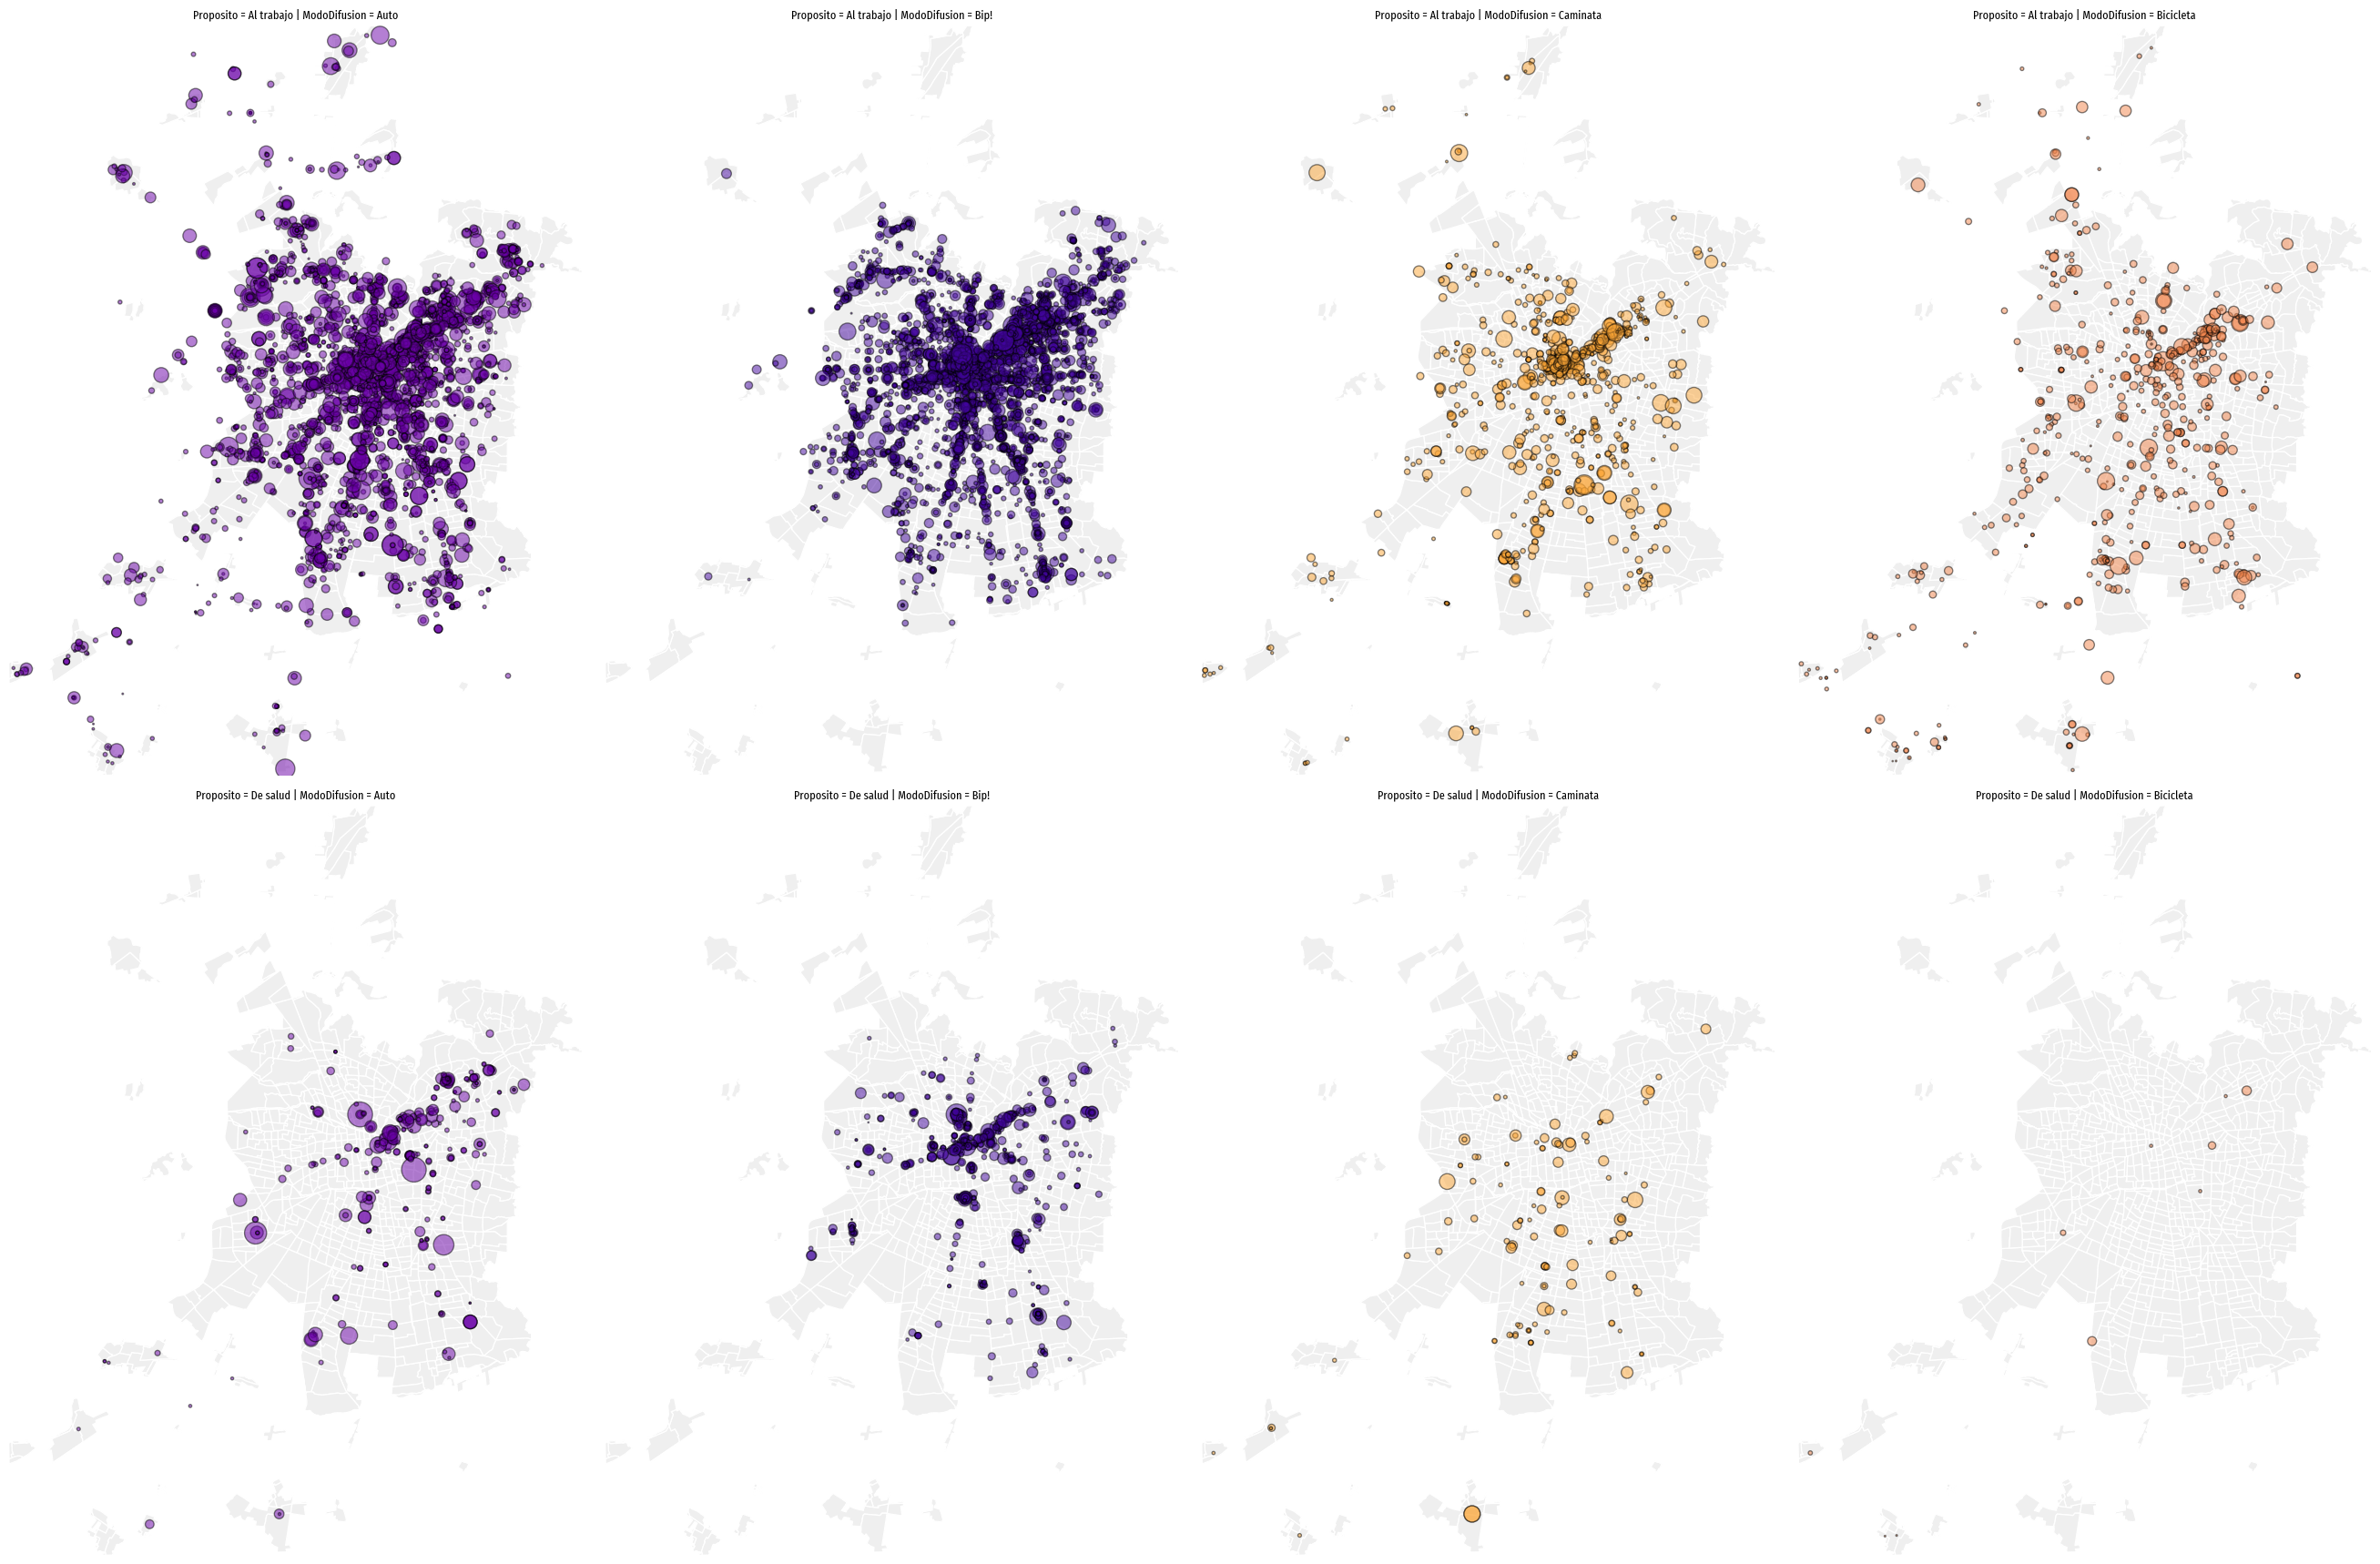

In [15]:
grid = GeoFacetGrid(
    origenes_viajes,
    context=zones,
    row="Proposito",
    col="ModoDifusion",
    row_order=["Al trabajo", "De salud"],
    col_order=["Auto", "Bip!", "Caminata", "Bicicleta"],
    height=9,
    hue="ModoDifusion",
    palette="plasma",
)

grid.add_layer(zones, color="#efefef", edgecolor="white", linewidth=1)
grid.add_layer(bubble_map, size="PesoLaboral", scale=0.15, edgecolor="black", alpha=0.5)


¡Mucho mejor! Sin embargo, la sobreposición de las burbujas sigue siendo un problema. No logramos ver la distribución debido a la oclusión de los puntos.

La solución es usar un `heat_map`. Así se ve un heatmap sobre todos los viajes al trabajo. Solo debemos reemplazar el uso de `bubble_map` por `heat_map` (y usar los parámetros correspondientes):

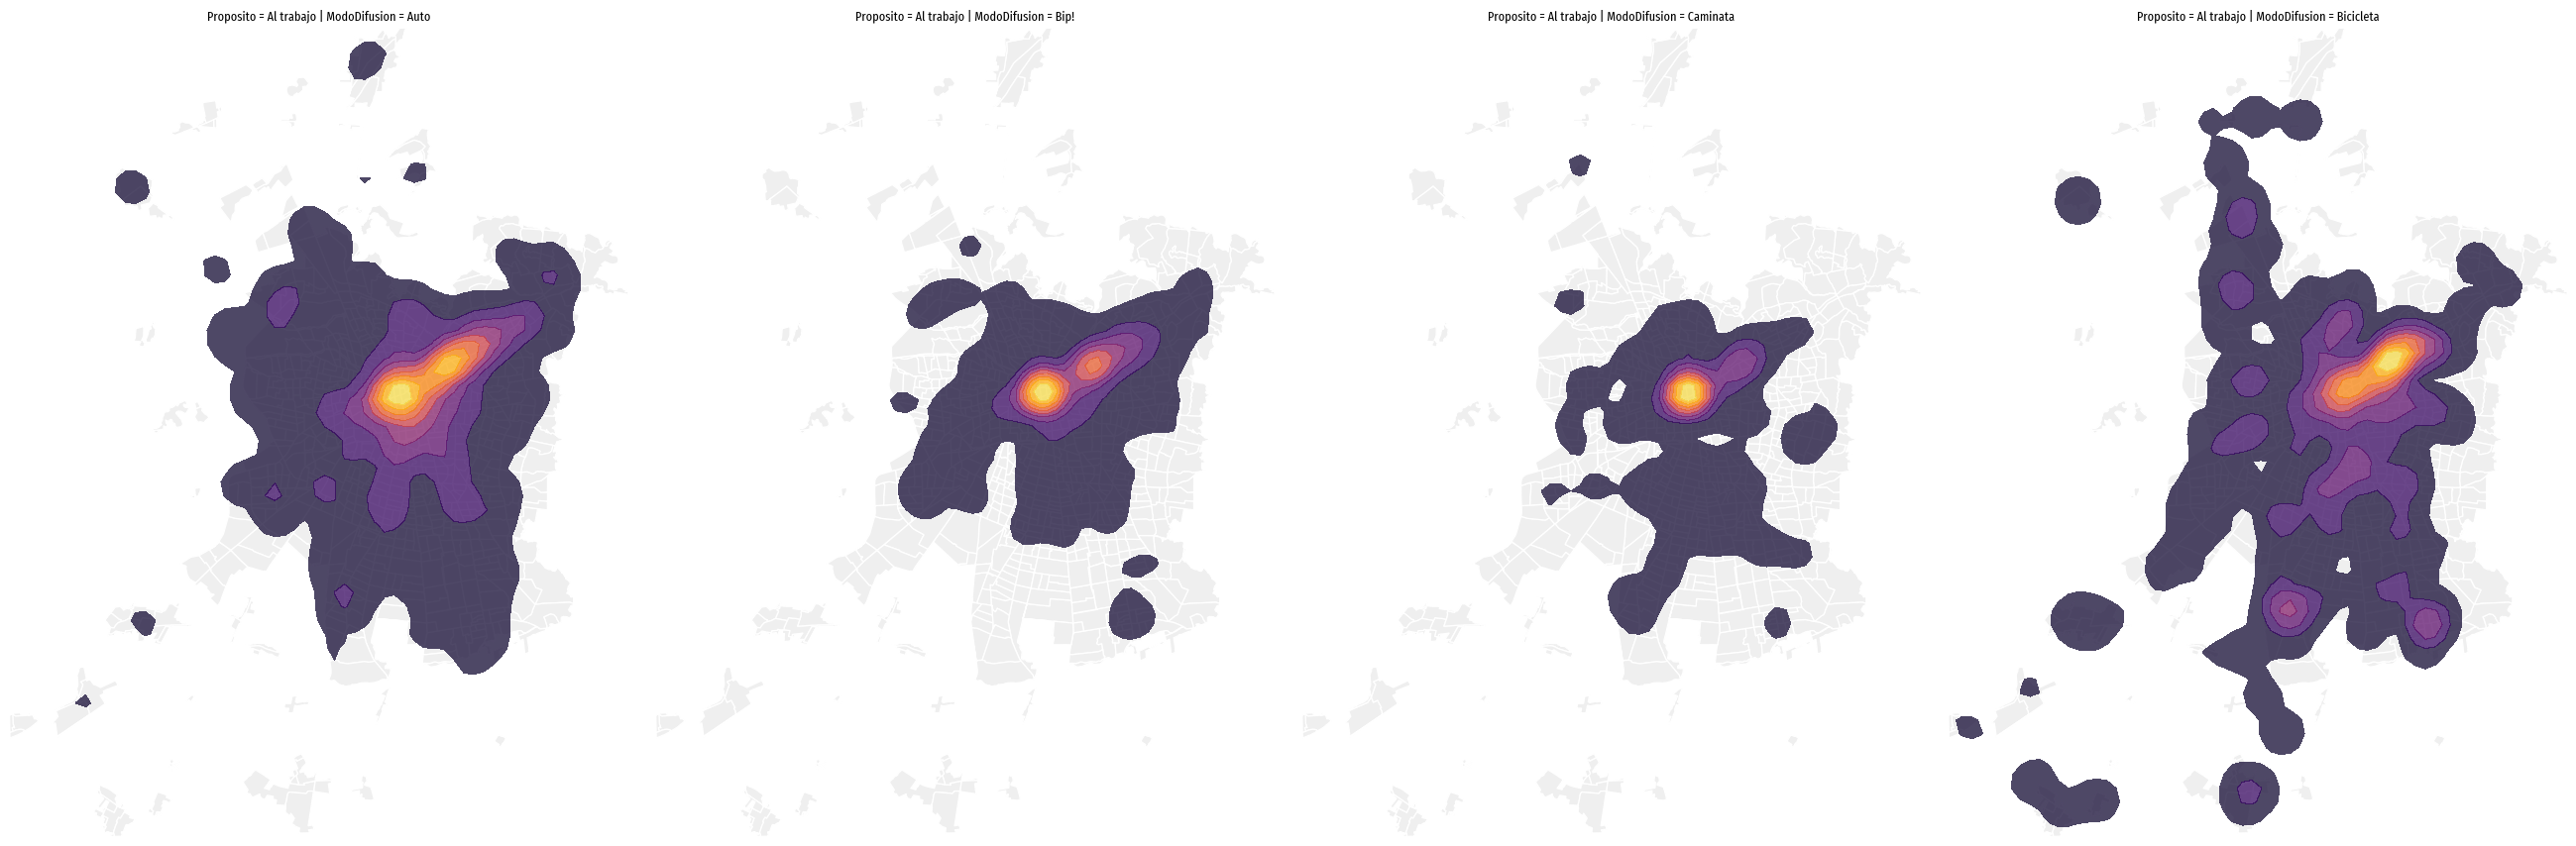

In [16]:
from aves.visualization.maps import heat_map

grid = GeoFacetGrid(
    origenes_viajes,
    context=zones,
    row="Proposito",
    col="ModoDifusion",
    row_order=["Al trabajo"],
    col_order=["Auto", "Bip!", "Caminata", "Bicicleta"],
    height=9,
    hue="ModoDifusion"
)

grid.add_layer(zones, color="#efefef", edgecolor="white", linewidth=1)

grid.add_layer(
    heat_map,
    # atributo de los datos con la importancia o peso de cada viaje
    weight="PesoLaboral",
    # cantidad de niveles/colores del mapa de calor
    n_levels=10,
    # radio de influencia de cada viaje
    bandwidth=1000,
    # valor de corte para los valores bajos del heatmap
    low_threshold=0.025,
    # transparencia
    alpha=0.75,
    # paleta de colores
    palette="inferno"
)


Esta técnica de visualización responde nuestra pregunta: nos dice dónde hay concentración, y, al mismo tiempo, deduce una forma, unos límites, para esos lugares que concentran actividad.

Pero hay algo extraño en el gráfico. Solo vemos concentración en uno o dos lugares de la ciudad. Queríamos analizar de acuerdo al lugar de residencia de las personas, en un tipo de viaje importante, pero no estamos viendo mapas que nos hagan pensar en residencia. ¿Qué sucede?

La respuesta es que nos fijamos en los orígenes de los viajes al trabajo, pero **sin discriminar que el viaje al trabajo fuese desde el hogar de las personas**. Y, en un día laboral normal, usualmente se hacen dos viajes al trabajo. Uno desde la casa, y otro al regresar al trabajo luego de comer.

Hay soluciones para esto. La primera sería corregir ese análisis. No lo haremos puesto que no es una clase de análisis de datos. Queda como problema propuesto.

La segunda es utilizar los destinos de los viajes. En un día laboral normal podemos asumir que es común que solo se regrese a casa una vez, y que ese regreso se realice en el modo de transporte principal. 

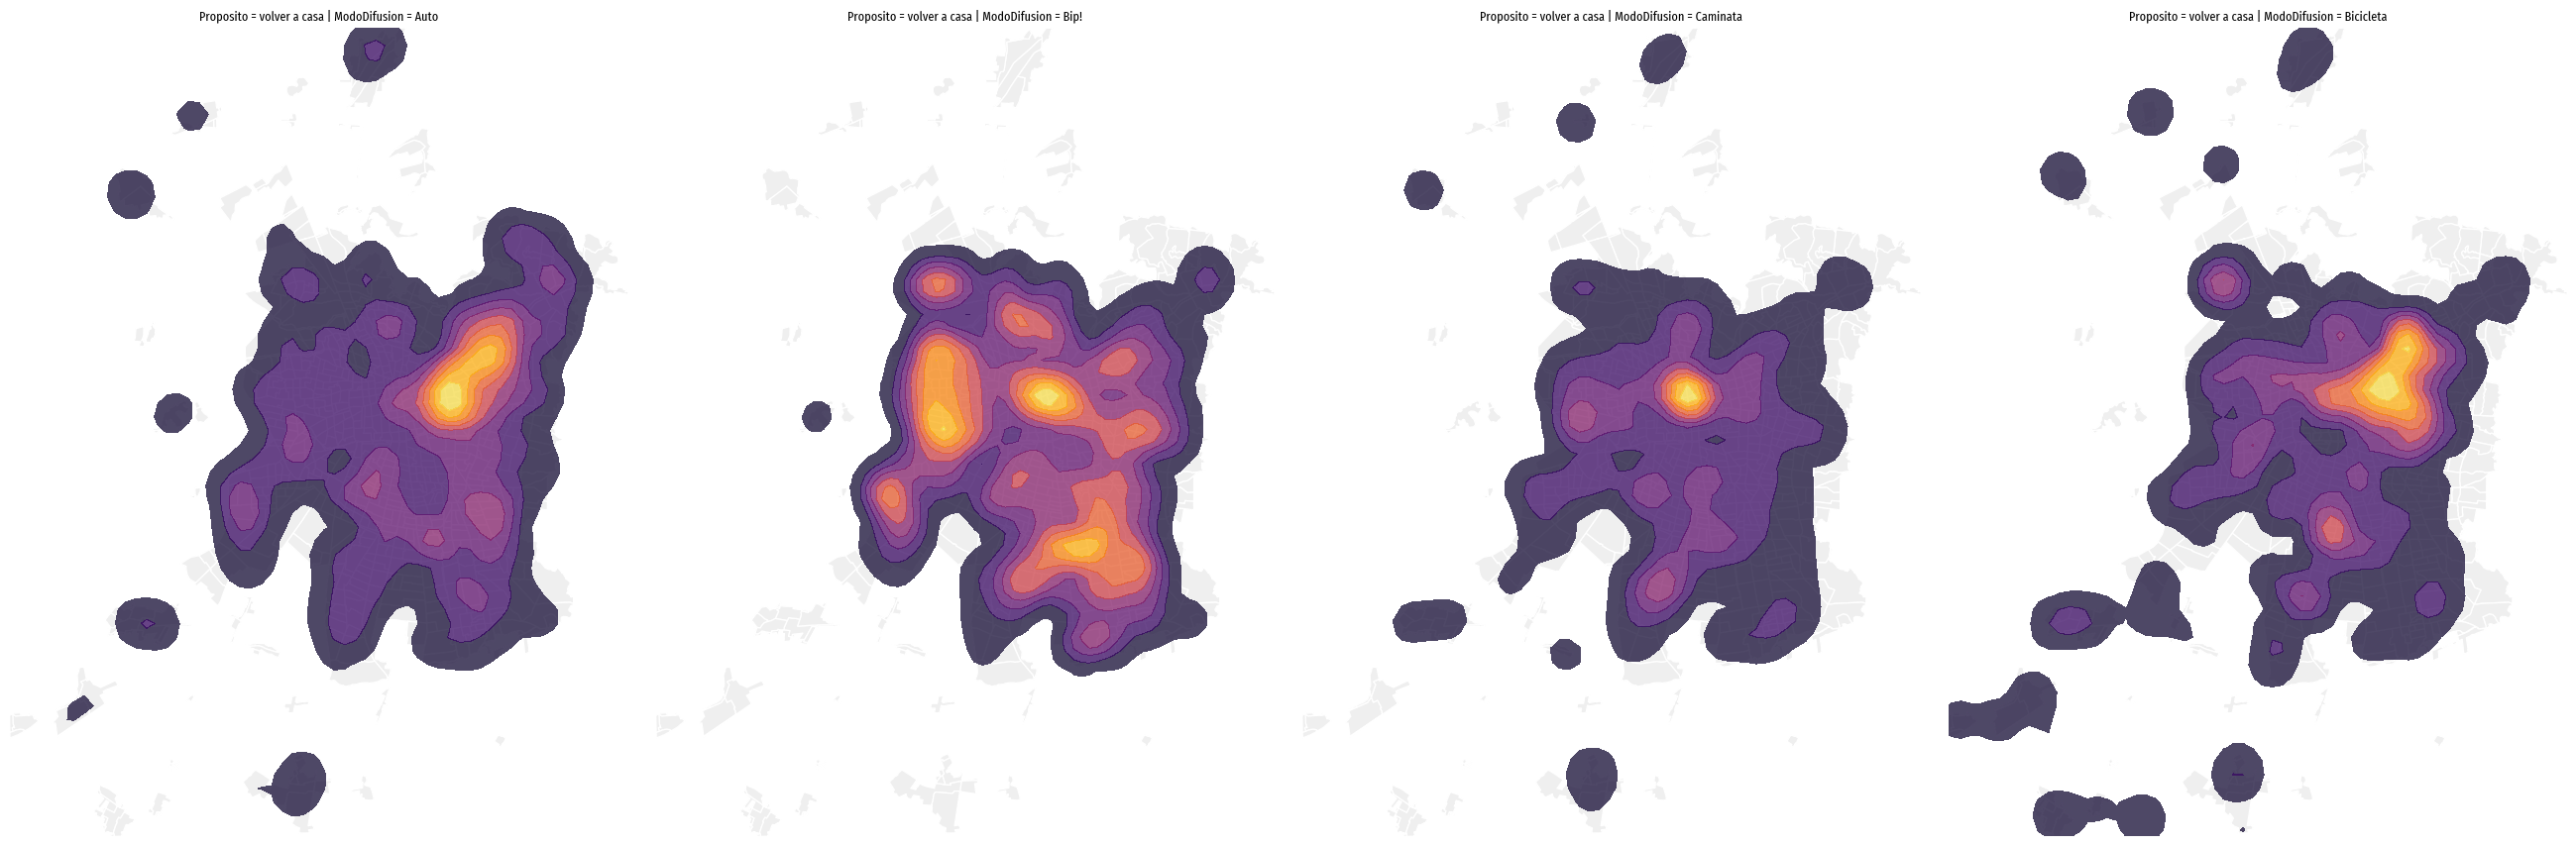

In [17]:
grid = GeoFacetGrid(
    destinos_viajes,
    context=zones,
    col="ModoDifusion",
    row="Proposito",
    row_order=["volver a casa"],
    col_order=["Auto", "Bip!", "Caminata", "Bicicleta"],
    height=9,
)

grid.add_layer(zones, color="#efefef", edgecolor="white", linewidth=1)
grid.add_layer(
    heat_map,
    weight="PesoLaboral",
    n_levels=10,
    bandwidth=1000,
    low_threshold=0.025,
    alpha=0.75,
    palette="inferno",
)


Configuremos el gráfico para que sea más amigable. Haremos lo siguiente:

- Haremos un gráfico de 2x2. Para ello necesitamos filtrar por nuestra cuenta los datos, de modo que el objeto `grid` pueda disponer de las filas (o de las columnas) repitiendo valores.
- Agregaremos como base la imagen del territorio que descargamos en el notebook anterior.
- Utilizaremos una leyenda de colores para explicar cuál es el color asociado a la concentración.

/home/egraells/miniconda3/envs/aves/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


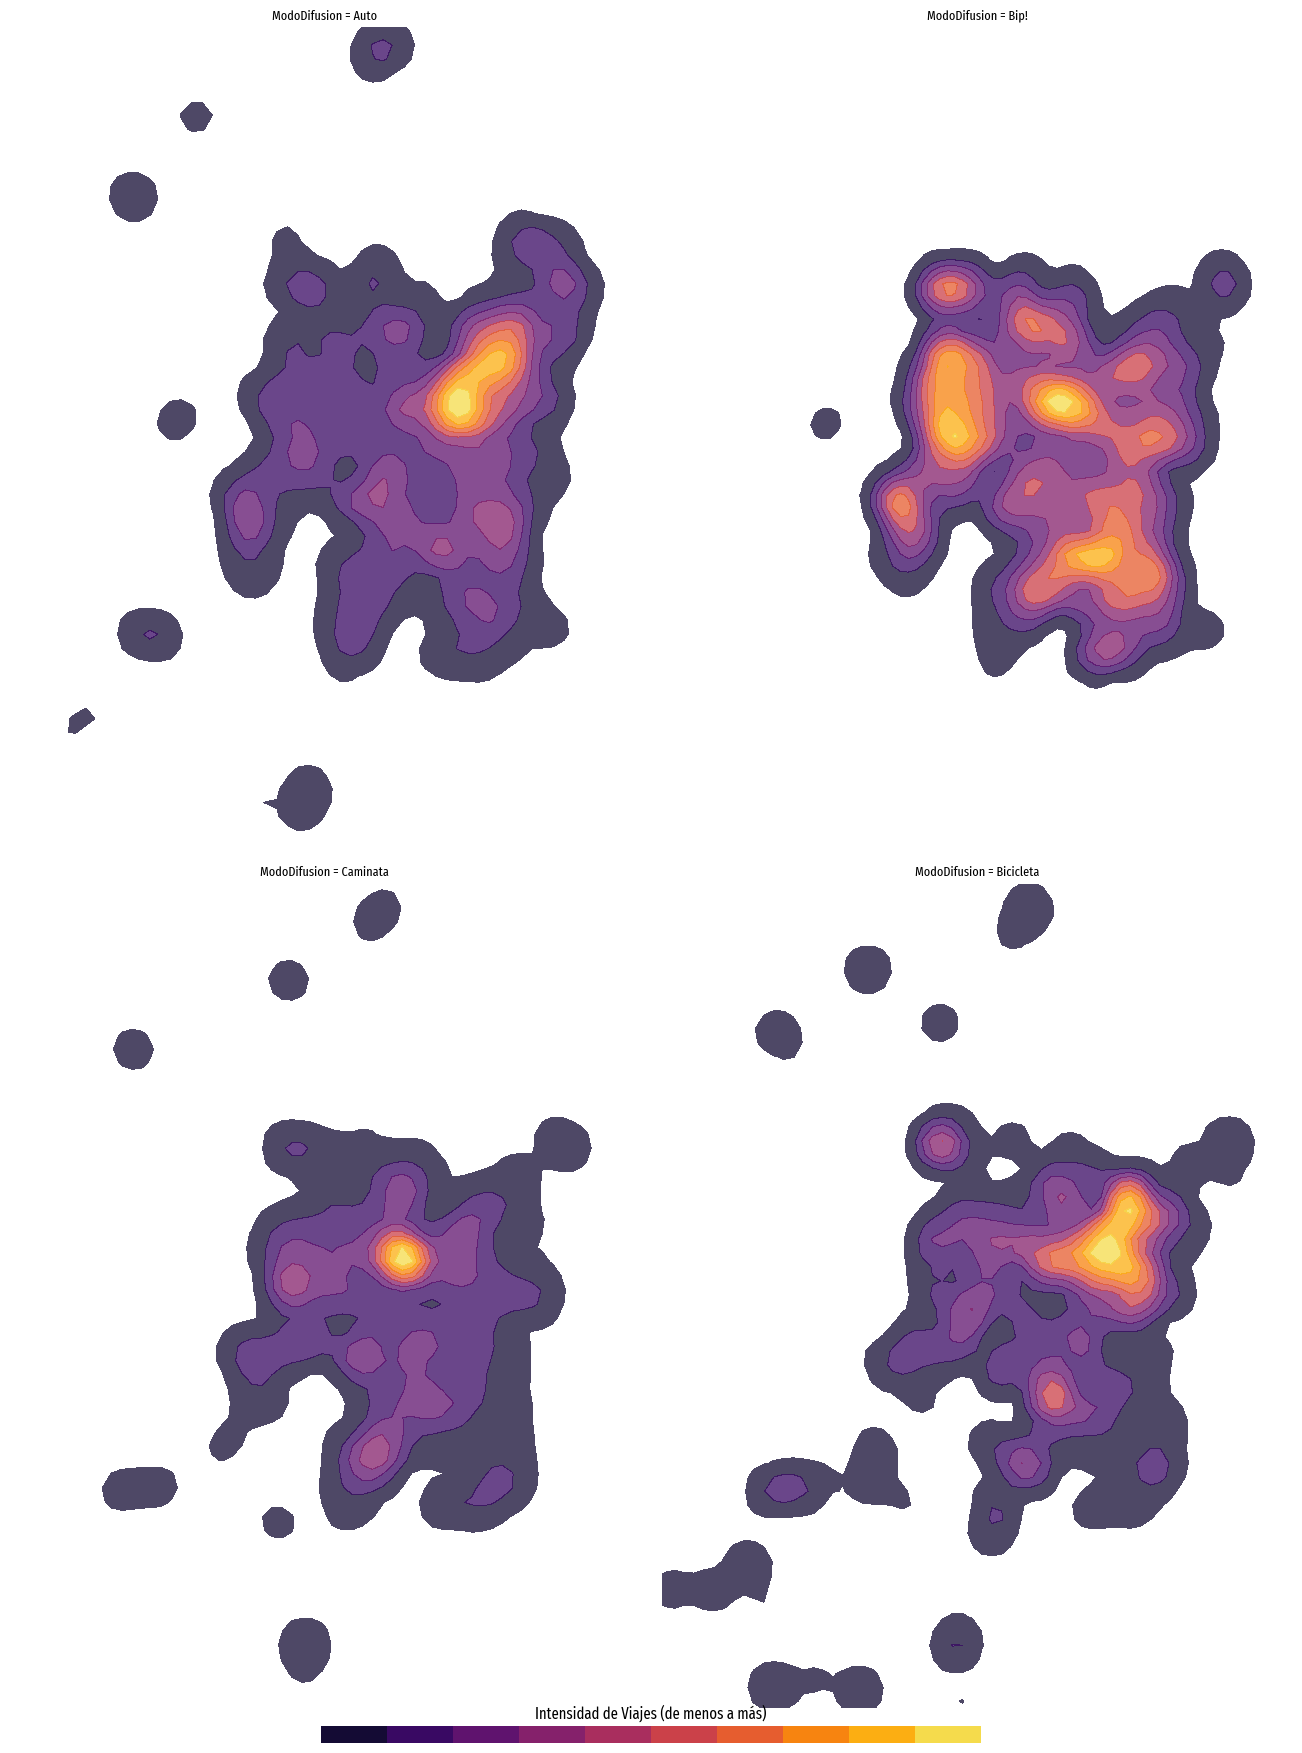

In [18]:
grid = GeoFacetGrid(
    destinos_viajes[destinos_viajes["Proposito"] == "volver a casa"],
    context=zones,
    col="ModoDifusion",
    col_wrap=2,
    col_order=["Auto", "Bip!", "Caminata", "Bicicleta"],
    height=9,
)

#grid.add_basemap(AVES_ROOT / "data" / "processed" / "scl_toner_12.tif")
grid.add_layer(
    heat_map,
    weight="PesoLaboral",
    n_levels=10,
    bandwidth=1000,
    low_threshold=0.025,
    alpha=0.75,
    palette="inferno",
)
grid.add_global_colorbar(
    "inferno",
    10,
    title="Intensidad de Viajes (de menos a más)",
    orientation="horizontal",
)
grid.tight_layout()

# grid.savefig('../reports/figures/example_geofacetgrid.png', dpi=150)


Agregar el contexto territorial nos permite ver cosas como el rol segregador que juega la autopista Américo Vespucio. **¿Qué otras cosas ven ustedes?**

Ejercicio propuesto:

- Consideren el análisis por grupos etáreos que hicimos la clase pasada. Definan categorías de grupos y determinen cuáles lugares de la ciudad visitan, tanto en general como por propósito de viaje. Rangos de ejemplo incluyen: menores de edad (< 18 años), adultos mayores (> 65 años), etc. 

## ¿Cuán lejos queda el trabajo de acuerdo al lugar de residencia?

Con esta pregunta queremos entender si existe un patrón geográfico en las elecciones de residencia y trabajo de las personas.

Para responder la pregunta, primero filtramos los viajes que nos interesan:

In [19]:
viajes_trabajo = origenes_viajes[(origenes_viajes.Proposito == 'Al trabajo') &
                                (pd.notnull(origenes_viajes.PesoLaboral)) &
                                (origenes_viajes.DistEuclidiana > 0)].drop_duplicates(subset='Persona', keep='first')
                                
print(len(viajes_trabajo), viajes_trabajo.PesoLaboral.sum())

11228 2376297.558364344


Observamos que, si bien son 11228 filas en la tabla.

La columna `DistEuclidiana` contiene la distancia entre los puntos de origen y destino de los viajes.

No todos los viajes al trabajo se efectúan desde la casa, ni una persona hace un único viaje al trabajo durante el día. Como una manera de alivianar el problema nos quedamos con un único viaje al trabajo por persona.

Veamos la distribución de la distancia:

In [20]:
viajes_trabajo['DistEuclidiana'].describe()

count     11228.000000
mean       9796.056644
std        8255.172371
min           1.000000
25%        3617.000000
50%        8016.000000
75%       14156.250000
max      227929.000000
Name: DistEuclidiana, dtype: float64

Ahora bien, el promedio que nos entregó el método `pd.describe` no considera la representatividad de cada viaje. Podemos utilizar la función `weighted_mean` de aves para calcular el promedio ponderado:

In [21]:
from aves.features.utils import weighted_mean

viajes_trabajo['DistEuclidiana'].mean(), weighted_mean(viajes_trabajo, 'DistEuclidiana', 'PesoLaboral')

(9796.056644104026, 9252.127879709067)

En este caso, el promedio ponderado no está _tan_ lejos del promedio sin ponderar, pero nada asegura que esa diferencia sea pequeña en toda la ciudad.

Podemos calcular la distancia promedio al trabajo por zona haciendo una operación `pd.groupby`:

In [22]:
distancia_zonas = (viajes_trabajo
                   .groupby(['ZonaOrigen'])
                   .apply(lambda x: weighted_mean(x, 'DistEuclidiana', 'PesoLaboral'))
                   .rename('distancia_al_trabajo')
)

distancia_zonas

ZonaOrigen
1        6452.138966
2        5952.584070
3        4091.135703
4        4731.477408
5       17567.000000
           ...      
858     18184.397206
859     17326.810773
860     16682.473531
861     12782.225811
999    126131.197560
Name: distancia_al_trabajo, Length: 749, dtype: float64

La serie contiene, para cada zona, la distancia promedio al trabajo de la gente que vive en ella (y posiblemente otras más). Si queremos ver esta distribución podemos utilizar el método `plot(kind='kde')`, como hicimos en notebooks anteriores:

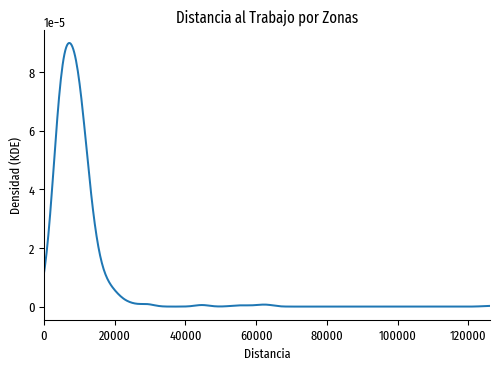

In [23]:
distancia_zonas.plot(kind='kde')
plt.xlim([0, distancia_zonas.max()])
plt.title('Distancia al Trabajo por Zonas')
plt.xlabel('Distancia')
plt.ylabel('Densidad (KDE)')
sns.despine()

Ahora bien, esta distribución solamente nos permite saber propiedades estádisticas. ¡No tenemos un contexto geográfico! Por eso necesitamos el mapa, para saber si la distancia tiene relación con la ubicación de cada zona en la ciudad, con saber si zonas que están cerca entre sí tienen distancias al trabajo similares.

Como tenemos los valores de distancia por zona, un _choropleth map_ nos permitiría mostrar la distancia asociada a cada zona al mismo tiempo que su posición geográfica. 

/tmp/ipykernel_7911/1616757827.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


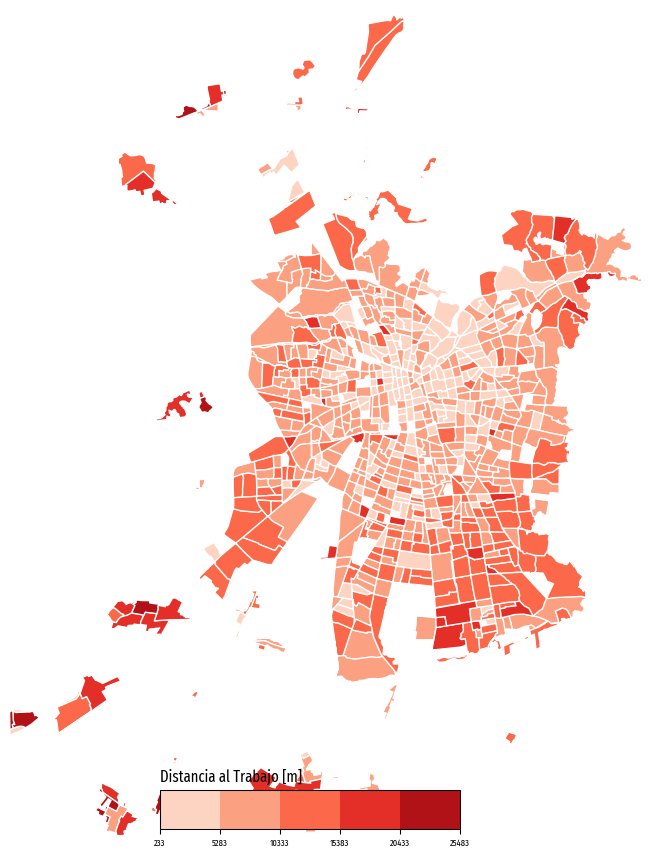

In [24]:
from aves.visualization.maps import choropleth_map

fig, ax = figure_from_geodataframe(zones, height=9, remove_axes=True)

ax, cax = choropleth_map(ax, zones.join(distancia_zonas, how='inner'), 'distancia_al_trabajo', k=5)
cax.set_title('Distancia al Trabajo [m]', loc='left')

fig.tight_layout()

La leyenda explica que valores más claros tienen menores distancias al trabajo. Al mismo tiempo, observamos la concentración de los trabajos en la ciudad: las zonas más claras tienden a aparecer en Santiago, Providencia, Las Condes, y sus alrededores. Como consecuencia, las zonas periféricas tienen una distancia al trabajo mayor: casi toda la periferia está compuesta de zonas oscuras.

¿cómo se calculan los rangos que son representados por cada color? 

Existen varias alternativas. La opción por omisión es dividir el intervalo de valores posibles en rangos uniformes (opción `binning='uniform'`). Otra es dividir las observaciones en cuantiles (opción `binning='quantiles'`). Y otra es utilizar el esquema llamado [_Natural Breaks_](https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization), que busca la mejor manera de clasificar datos en un número específico de categorías (una especie de clustering _K-Means_ en una dimensión). Lo podemos especificar en la función de dibujo con el parámetro `binning='fisher_jenks'` ([se llama así porque lo inventó _Jenks_ y lo mejoró _Fisher_](http://wiki.objectvision.nl/index.php/Fisher's_Natural_Breaks_Classification)).

Usemos la función `small_multiples_from_geodataframe` para comparar estas tres estrategias de codificación visual en el canal de color:

/tmp/ipykernel_7911/1756130274.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


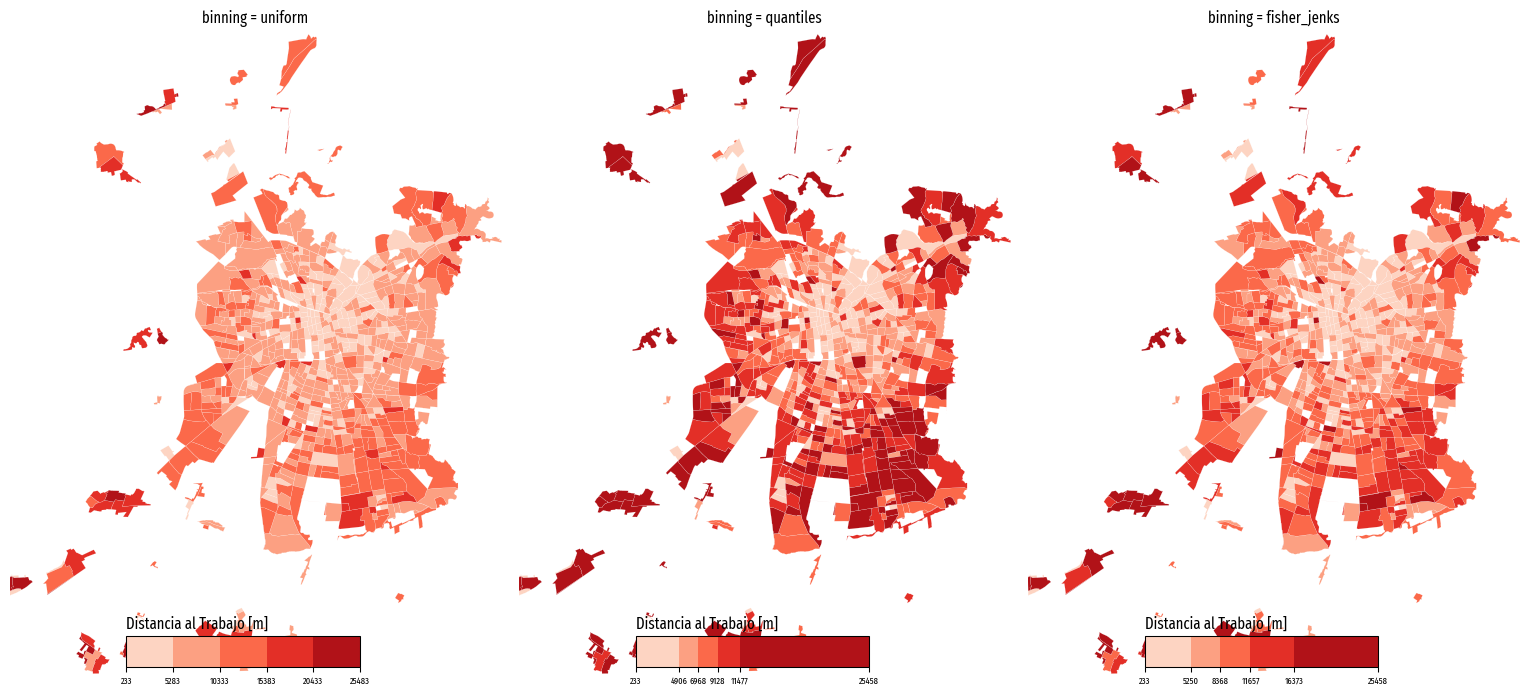

In [25]:
from aves.visualization.figures import small_multiples_from_geodataframe

fig, axes = small_multiples_from_geodataframe(zones, 3, 7)

for binning, ax in zip(['uniform', 'quantiles', 'fisher_jenks'], axes):
    ax.set_title(f'binning = {binning}')
    _, cax = choropleth_map(ax, zones.join(distancia_zonas, how='inner'), 'distancia_al_trabajo', k=5, binning=binning, linewidth=0.1)
    cax.set_title('Distancia al Trabajo [m]', loc='left')

fig.tight_layout()

¿Cuál esquema les parece mejor (para una definición de "mejor" elegida por ustedes)? Cada uno tiene sus ventajas y desventajas. 

¿Qué otro patrón observan en este mapa? ¿Qué más harían?

**¿Se imaginan este mapa mezclado con los mapas anteriores?** Ése es un ejercicio propuesto.

El esquema de Fisher-Jenks es utilizado con frecuencia posiblemente porque balancea los aspectos de los otros esquemas. Lo utilizaremos para la versión final del mapa, esta vez con información contextual. Además de la información territorial, agregaremos elementos típicos de los mapas cartográficos: una escala y una flecha hacia el norte.

/home/egraells/miniconda3/envs/aves/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


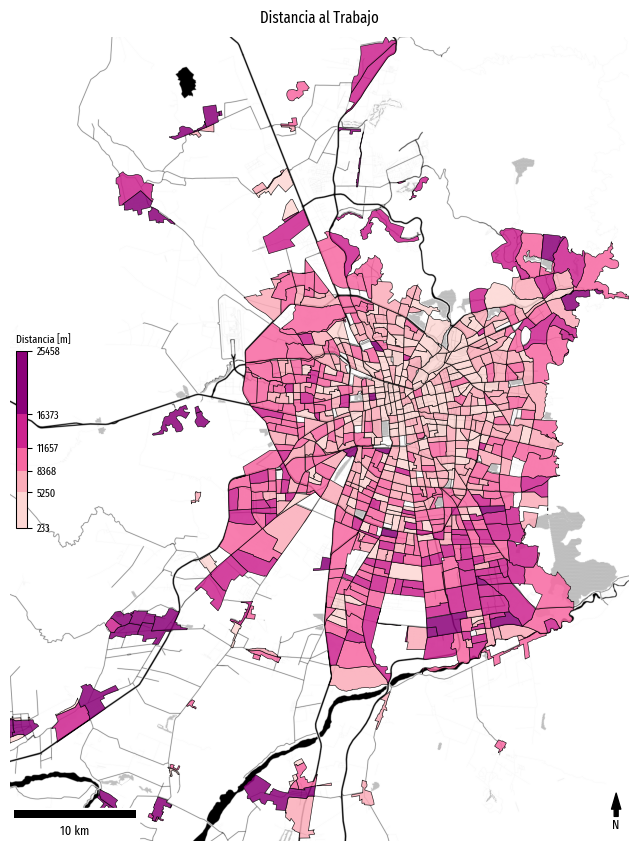

In [26]:
grid = GeoFacetGrid(zones.join(distancia_zonas, how="inner"), height=9)

grid.add_basemap(AVES_ROOT / "data" / "processed" / "scl_toner_12.tif")

grid.add_layer(
    choropleth_map,
    "distancia_al_trabajo",
    k=5,
    linewidth=0.5,
    edgecolor="black",
    binning="fisher_jenks",
    palette="RdPu",
    alpha=0.85,
    cbar_args=dict(
        label="Distancia [m]",
        height="22%",
        width="2%",
        orientation="vertical",
        location="center left",
        label_size="small",
        bbox_to_anchor=(0.0, 0.0, 0.9, 1.0),
    ),
)
grid.add_map_elements()
grid.set_title("Distancia al Trabajo")
grid.tight_layout()

#grid.savefig('../reports/figures/example_choropleth.png', dpi=150)


De esta manera el mapa nos permite caracterizar las zonas, y conjuntos de zonas, de acuerdo a la distancia que deben recorrer sus habitantes para ir al trabajo. 

Queda propuesto desagregar este mapa por características de las personas, como su nivel socioeconómico.